In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
from torchvision.models.vgg import model_urls
from models.models import Custom_AlexNet, Custom_ResNet34, Custom_VGG16

# All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn as nn 
import torch.nn.functional as F

# For all Optimization algorithms, SGD, Adam, etc.
import torch.optim as optim

# Loading and Performing transformations on dataset
import torchvision
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import Sampler, WeightedRandomSampler

#Labels in CSV and Inputs in Fits in a folder
import pandas as pd
import sunpy.map
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

#For Confusion Matrix
from sklearn.metrics import confusion_matrix

#Warnings
import warnings
warnings.simplefilter("ignore", Warning)

#Time Computation
import timeit

In [2]:
class MyJP2Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)

        if self.transform:
            image = self.transform(hmi)
            
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)
    
class RotateAugmentation(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv1 = pd.read_csv(csv_file, iterator=True)
        iter_csv2 = pd.read_csv(csv_file, iterator=True)
        df1 = pd.concat([chunk[chunk['goes_class'] == 1] for chunk in iter_csv1])
        df2 = pd.concat([chunk[chunk['goes_class'] == 2] for chunk in iter_csv2])
        df  = pd.concat([df1, df2])
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print(y_label)

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)
    
class FlipAugmentation(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv1 = pd.read_csv(csv_file, iterator=True)
        iter_csv2 = pd.read_csv(csv_file, iterator=True)
        df1 = pd.concat([chunk[chunk['goes_class'] == 1] for chunk in iter_csv1])
        df2 = pd.concat([chunk[chunk['goes_class'] == 2] for chunk in iter_csv2])
        df  = pd.concat([df1, df2])
        self.annotations = df
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print(y_label)

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.backends.cudnn.benchmark = True
print(device)

cuda:0


In [4]:
torch.cuda.current_device()

0

In [5]:
# Load Data
transformations = transforms.Compose([
    transforms.CenterCrop(3300),
    transforms.Resize(512),
    transforms.ToTensor()
])


rotation = transforms.Compose([
    transforms.CenterCrop(3300),
    transforms.RandomRotation(degrees=(-5,5)),
    transforms.Resize(512),
    transforms.ToTensor()
])


flip = transforms.Compose([
    transforms.CenterCrop(3300),
    transforms.RandomChoice([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0)]),
    transforms.Resize(512),
    transforms.ToTensor()
])

#Train Time-Based Split -- Data from 2010-2014 in Train Set
original_train = MyJP2Dataset(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_train.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = transformations)
rotation_set = RotateAugmentation(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_train.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = rotation)

flip_set = FlipAugmentation(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_train.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = flip)

train_set = ConcatDataset([flip_set, original_train, rotation_set])
print(2*len(rotation_set), len(original_train), len(train_set))
#Data From 2015-2018 are randomly splitted into 40% and 60% into validation and test set resp.
val_set = MyJP2Dataset(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_val.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = transformations)

2206 4232 6438


In [6]:
def imbalance_weights(dataset):
    target = []
    with torch.no_grad():
        for i in range(len(dataset)):
            target.append(np.asarray(dataset[i][1]))
            if i%500 == 0:
                print(f'{(i*100)/len(dataset):.2f}% Complete')
        targets = np.asarray(target)
        csc = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
        print(csc)
        weight = 1. / csc
        samples_weight = np.array([weight[t] for t in target])

        samples_weight = torch.from_numpy(samples_weight)
        samples_weigth = samples_weight.double()
        return samples_weigth

train_samples_weight = imbalance_weights(train_set)
#test_samples_weight = imbalance_weights(test_set)
#val_samples_weight = imbalance_weights(val_set)

0.00% Complete
7.77% Complete
15.53% Complete
23.30% Complete
31.07% Complete
38.83% Complete
46.60% Complete
54.36% Complete
62.13% Complete
69.90% Complete
77.66% Complete
85.43% Complete
93.20% Complete
[3129 1611 1698]


In [7]:
batch_size = 24
sampler1   = WeightedRandomSampler(weights=train_samples_weight, num_samples= len(train_samples_weight), replacement=True)
#sampler2  = WeightedRandomSampler(weights=test_samples_weight, num_samples= len(test_samples_weight), replacement=True)
#sampler3  = WeightedRandomSampler(weights=val_samples_weight, num_samples= int(200), replacement=False)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, sampler=sampler1,  num_workers=4, shuffle = False)

val_loader = DataLoader(dataset=val_set, batch_size=batch_size, num_workers=4, shuffle=False)

#test_loader = DataLoader(dataset=test_set, batch_size=batch_size, num_workers=4, shuffle=False)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/1/2: {}/{}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0]),
        len(np.where(target.numpy() == 2)[0])))
    if i==3:
        break

batch index 0, 0/1/2: 8/11/5
batch index 1, 0/1/2: 8/11/5
batch index 2, 0/1/2: 10/9/5
batch index 3, 0/1/2: 5/11/8


In [8]:
def visualize(data_loader):
    cmap = plt.get_cmap('hmimag')
    dataiter = iter(data_loader)
    #dataiter.next()
    images, labels = dataiter.next()
    flare_types = {0: 'Non_flare', 1: 'Flare'}
    fig, axis = plt.subplots(5, 5, figsize=(15, 15))
    for i, ax in enumerate(axis.flat):
        with torch.no_grad():
            image, label = images[i], labels[i]
            ax.imshow(image.permute(1,2,0), cmap=cmap, vmin=0, vmax=1) # add image
            ax.set(title = f"{flare_types[label.item()]}")

#visualize(train_loader)

In [9]:
# Hyperparameters

in_channel = 1
learning_rate = 0.01
num_epochs = 80


model = Custom_VGG16(ipt_size=(512, 512), pretrained=True, num_classes=3).to(device)

# Loss and optimizer

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [10]:
def sklearn_Compatible_preds_and_targets(model_prediction_list, model_target_list):
    y_pred_list = []
    preds = []
    target_list = []
    tgts = []
    y_pred_list = [a.squeeze().tolist() for a in model_prediction_list]
    preds = [item for sublist in y_pred_list for item in sublist]
    target_list = [a.squeeze().tolist() for a in model_target_list]
    tgts = [item for sublist in target_list for item in sublist]
    return tgts, preds

def get_labeled_confusion_matrix(y_true, y_pred, labels):
    from sklearn.metrics import confusion_matrix
    ind_list = ['true:{}'.format(l) for l in labels]
    col_list = ['pred:{}'.format(l) for l in labels]
    return pd.DataFrame(data=confusion_matrix(y_true, y_pred, labels=labels),index=ind_list, columns=col_list)

In [11]:
def TSS_mc(cmtx, labels):
    
    sum_of_trues = 0
    sum_marginal_mult = 0
    sum_of_squared_marginal_observed = 0
    print(cmtx)
    
    for i in labels:
        oi = 'true:{}'.format(i)
        pi = 'pred:{}'.format(i)
        N_Fi = cmtx['pred:{}'.format(i)].sum()
        N_Oi = cmtx.loc['true:{}'.format(i)].sum()
        
        sum_of_trues += cmtx.loc[oi, pi]
        sum_marginal_mult += N_Fi*N_Oi
        sum_of_squared_marginal_observed += N_Oi*N_Oi

    N = cmtx.sum().sum()
    TSS_mc = (sum_of_trues/N - sum_marginal_mult/(N*N) ) / (1 - sum_of_squared_marginal_observed/(N*N) )
    return TSS_mc


def HSS_mc(cmtx, labels):
    
    sum_of_trues = 0
    sum_marginal_mult = 0
    
    for i in labels:
        oi = 'true:{}'.format(i)
        pi = 'pred:{}'.format(i)
        N_Fi = cmtx['pred:{}'.format(i)].sum()
        N_Oi = cmtx.loc['true:{}'.format(i)].sum()
        
        sum_of_trues += cmtx.loc[oi, pi]
        sum_marginal_mult += N_Fi*N_Oi

    N = cmtx.sum().sum()
    HSS_mc = (sum_of_trues/N - sum_marginal_mult/(N*N) ) / (1 - sum_marginal_mult/(N*N) )
    return HSS_mc


In [12]:
# Training Network
print("Training in Progress..")
labels = [0, 1, 2]
train_loss_values = []
val_loss_values = []
train_tss_values = []
val_tss_values = []
train_hss_values = []
val_hss_values = []
train_time = []
val_time = []
learning_rate_values = []
for epoch in range(num_epochs):
    
    #Timer for Training one epoch
    start_train = timeit.default_timer() 
    
    # setting the model to train mode
    model.train()
    train_loss = 0
    train_tss = 0.
    train_hss = 0.
    train_prediction_list = []
    train_target_list = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        train_target_list.append(targets)
        
        # forward prop
        scores = model(data)
        loss = criterion(scores, targets)
        _, predictions = torch.max(scores,1)
        train_prediction_list.append(predictions)
        
        # backward prop
        optimizer.zero_grad()
        loss.backward()
        
        # Adam step
        optimizer.step()
        
        # accumulate the training loss
        #print(loss.item())
        train_loss += loss.item()
        #train_acc+= acc.item()
        
    stop_train = timeit.default_timer()
    train_time.append(stop_train-start_train)
    # Validation: setting the model to eval mode
    model.eval()
    start_val = timeit.default_timer()
    val_loss = 0.
    val_tss = 0.
    val_hss = 0.
    val_prediction_list = []
    val_target_list = []
    # Turning off gradients for validation
    with torch.no_grad():
        for d, t in val_loader:
            # Get data to cuda if possible
            d = d.to(device=device)
            t = t.to(device=device)
            val_target_list.append(t)
            
            # forward pass
            s = model(d)
            #print("scores", s)
                                   
            # validation batch loss and accuracy
            l = criterion(s, t)
            _, p = torch.max(s,1)
            #print("------------------------------------------------")
            #print(torch.max(s,1))
            #print('final', p)
            val_prediction_list.append(p)
            
            # accumulating the val_loss and accuracy
            val_loss += l.item()
            #val_acc += acc.item()
            del d,t,s,l,p
    scheduler.step(val_loss)
    stop_val = timeit.default_timer()
    val_time.append(stop_val-start_val)
    learning_rate_values.append(optimizer.param_groups[0]['lr'])
    
    #Epoch Results
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)
    y_true, y_pred = sklearn_Compatible_preds_and_targets(train_prediction_list, train_target_list)
    print("Train--CMTX")
    train_tss = TSS_mc( get_labeled_confusion_matrix(y_true, y_pred, labels), labels )
    train_hss = HSS_mc( get_labeled_confusion_matrix(y_true, y_pred, labels), labels )
    train_tss_values.append(train_tss)
    train_hss_values.append(train_hss)
    print("Val--CMTX")
    y_true_val, y_pred_val = sklearn_Compatible_preds_and_targets(val_prediction_list, val_target_list)
    val_tss = TSS_mc( get_labeled_confusion_matrix(y_true_val, y_pred_val, labels), labels )
    val_hss = HSS_mc( get_labeled_confusion_matrix(y_true_val, y_pred_val, labels), labels )
    val_tss_values.append(val_tss)
    val_hss_values.append(val_hss)
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Training--> loss: {train_loss:.4f}, TSS: {train_tss:.4f}, HSS2: {train_hss:.4f} | Val--> loss: {val_loss:.4f}, TSS: {val_tss:.4f} | HSS2: {val_hss:.4f} ')

Training in Progress..
Train--CMTX
        pred:0  pred:1  pred:2
true:0    1291     435     403
true:1     569     759     808
true:2     433     736    1004
Val--CMTX
        pred:0  pred:1  pred:2
true:0     564     200     239
true:1      13      75     145
true:2       2      68     173
Epoch: 1/80
Training--> loss: 1.0102, TSS: 0.2115, HSS2: 0.2115 | Val--> loss: 1.0719, TSS: 0.3791 | HSS2: 0.2910 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    1580     343     211
true:1     528     959     696
true:2     284     692    1145
Val--CMTX
        pred:0  pred:1  pred:2
true:0     858     145       0
true:1     112     121       0
true:2      68     172       3
Epoch: 2/80
Training--> loss: 0.8827, TSS: 0.3586, HSS2: 0.3585 | Val--> loss: 0.6857, TSS: 0.2888 | HSS2: 0.2956 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    1673     329     160
true:1     460    1065     630
true:2     192     692    1237
Val--CMTX
        pred:0  pred:1  pred:2
true:0     997       3       3

Epoch    22: reducing learning rate of group 0 to 1.0000e-06.
Train--CMTX
        pred:0  pred:1  pred:2
true:0    1983      68      25
true:1      65    1973     148
true:2      25     175    1976
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      57      44
true:2      85      62      96
Epoch: 22/80
Training--> loss: 0.2086, TSS: 0.8821, HSS2: 0.8821 | Val--> loss: 1.1152, TSS: 0.3051 | HSS2: 0.3234 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    2018      87      30
true:1      74    1961     143
true:2      20     163    1942
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      57      44
true:2      85      62      96
Epoch: 23/80
Training--> loss: 0.2168, TSS: 0.8795, HSS2: 0.8795 | Val--> loss: 1.1153, TSS: 0.3051 | HSS2: 0.3234 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    2059      90      34
true:1      62    1928     122
true:2      22     152    1969
Val--CMTX
        pred:0  pred

Train--CMTX
        pred:0  pred:1  pred:2
true:0    2032      89      23
true:1      64    1946     149
true:2      28     177    1930
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      57      44
true:2      87      60      96
Epoch: 43/80
Training--> loss: 0.2154, TSS: 0.8765, HSS2: 0.8765 | Val--> loss: 1.1154, TSS: 0.3037 | HSS2: 0.3224 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    1989      85      22
true:1      73    1930     155
true:2      28     158    1998
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      57      44
true:2      87      60      96
Epoch: 44/80
Training--> loss: 0.2162, TSS: 0.8786, HSS2: 0.8786 | Val--> loss: 1.1154, TSS: 0.3037 | HSS2: 0.3224 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    1976      84      40
true:1      62    2018     113
true:2      20     167    1958
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      

Train--CMTX
        pred:0  pred:1  pred:2
true:0    2070      82      25
true:1      73    1953     150
true:2      26     159    1900
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      57      44
true:2      87      60      96
Epoch: 65/80
Training--> loss: 0.2135, TSS: 0.8800, HSS2: 0.8800 | Val--> loss: 1.1154, TSS: 0.3037 | HSS2: 0.3224 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    2035      77      31
true:1      77    1923     137
true:2      17     168    1973
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      57      44
true:2      87      60      96
Epoch: 66/80
Training--> loss: 0.2145, TSS: 0.8819, HSS2: 0.8819 | Val--> loss: 1.1154, TSS: 0.3037 | HSS2: 0.3224 
Train--CMTX
        pred:0  pred:1  pred:2
true:0    2011      73      30
true:1      62    1988     137
true:2      30     169    1938
Val--CMTX
        pred:0  pred:1  pred:2
true:0     865      79      59
true:1     132      

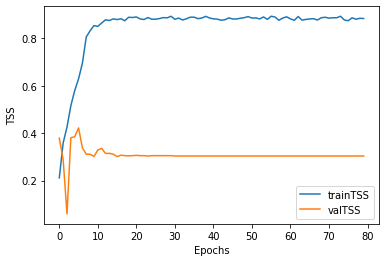

In [13]:
def plot_results(train_values, val_values, plt_type):
    plt.plot(train_values, label='train'+str(plt_type))
    plt.plot(val_values, label='val'+str(plt_type))
    plt.xlabel('Epochs')
    plt.ylabel(plt_type)
    plt.legend()
    plt.show()
    
plot_results(train_tss_values, val_tss_values, 'TSS') 
plot_results(train_loss_values, val_loss_values, 'LOSS')
plot_results(train_hss_values, val_hss_values, 'HSS2')

In [14]:
PATH = 'trained-models/vgg16-multi-fold4.pth'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
            }, PATH)

results = {
    'train_tss_values':train_tss_values,
    'val_tss_values':val_tss_values,
    'train_hss_values':train_hss_values,
    'val_hss_values':val_hss_values,
    'train_loss_values':train_loss_values,
    'val_loss_values':val_loss_values,
    'learning_rate': learning_rate_values,
    'train_time': train_time,
    'val_time': val_time
}
df = pd.DataFrame(results, columns=['train_tss_values','val_tss_values', 'train_hss_values', 'val_hss_values', 'train_loss_values', 'val_loss_values', 'learning_rate', 'train_time', 'val_time' ])
df.to_csv(r'results/vgg16-multi-fold4.csv', index=False, header=True)